# Quality Indicator Examples

This notebook demonstrates the use of quality indicators to assess the performance of multi-objective optimization algorithms. We will use NSGA-II to solve the Kursawe problem and evaluate the resulting Pareto front approximation using three quality indicators:

- **Additive Epsilon (EP)**: Measures the minimum additive factor needed to weakly dominate the reference front
- **Inverted Generational Distance (IGD)**: Measures the average distance from reference points to the closest solution
- **Inverted Generational Distance Plus (IGD+)**: An improved version of IGD using dominance-based distance

We will compare the indicators before and after front normalization to show the importance of proper data preprocessing.

In [2]:
using MetaJul
using DelimitedFiles
using Plots

## Step 1: Configure and Run NSGA-II on Kursawe Problem

First, we instantiate the Kursawe problem and configure NSGA-II with standard settings.

In [4]:
# Create the Kursawe problem instance
problem = kursawe()
println("Problem: Kursawe")
println("Number of variables: ", numberOfVariables(problem))
println("Number of objectives: ", numberOfObjectives(problem))

Problem: Kursawe
Number of variables: 3
Number of objectives: 2


In [5]:
# Configure NSGA-II with default settings
solver = NSGAII(problem)
println("NSGA-II configured with default settings")

NSGA-II configured with default settings


In [6]:
# Run the algorithm
println("Running NSGA-II...")
optimize!(solver)

println("Optimization completed")
println("Computing time: ", computingTime(solver), " seconds")
println("Number of solutions found: ", length(foundSolutions(solver)))

Running NSGA-II...
Optimization completed
Computing time: 1262 milliseconds seconds
Number of solutions found: 100


## Step 2: Visualize the Obtained Pareto Front

Let's plot the Pareto front approximation obtained by NSGA-II.

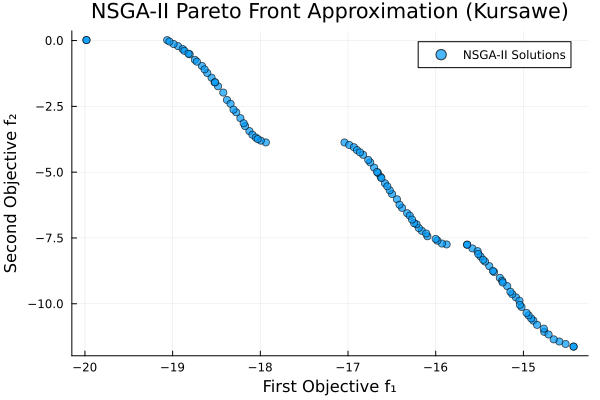

In [8]:
# Extract objectives for plotting
x = [solution.objectives[1] for solution in foundSolutions(solver)]
y = [solution.objectives[2] for solution in foundSolutions(solver)]

# Plot the Pareto front
gr()
scatter(x, y, title="NSGA-II Pareto Front Approximation (Kursawe)", 
        label="NSGA-II Solutions", markersize=4, alpha=0.7)
xlabel!("First Objective f₁")
ylabel!("Second Objective f₂")

## Step 3: Load Reference Front and Prepare Data

We load the true Pareto front for the Kursawe problem and prepare the data matrices for quality indicator computation.

In [10]:
# Load the reference Pareto front
kursawe_path = joinpath(@__DIR__, "..", "data", "referenceFronts", "Kursawe.csv")
reference_front = readdlm(kursawe_path, ',')

# Sort reference front by first objective for better plotting
reference_front = reference_front[sortperm(reference_front[:, 1]), :]

println("Reference front loaded and sorted")
println("Reference front size: ", size(reference_front))
println("Reference front bounds:")
println("  f₁: [", minimum(reference_front[:, 1]), ", ", maximum(reference_front[:, 1]), "]")
println("  f₂: [", minimum(reference_front[:, 2]), ", ", maximum(reference_front[:, 2]), "]")

Reference front loaded and sorted
Reference front size: (874, 2)
Reference front bounds:
  f₁: [-20.0, -14.44665867]
  f₂: [-11.62641325, 8.180035271e-11]


In [11]:
# Convert solution objectives to matrix format
front_objectives = [solution.objectives for solution in foundSolutions(solver)]
solution_front = hcat(front_objectives...)'

println("Solution front prepared")
println("Solution front size: ", size(solution_front))
println("Solution front bounds:")
println("  f₁: [", minimum(solution_front[:, 1]), ", ", maximum(solution_front[:, 1]), "]")
println("  f₂: [", minimum(solution_front[:, 2]), ", ", maximum(solution_front[:, 2]), "]")

Solution front prepared
Solution front size: (100, 2)
Solution front bounds:
  f₁: [-19.982674060471638, -14.428104909672577]
  f₂: [-11.626913674993098, 0.018211066453655167]


## Step 4: Visualize Both Fronts Together

Let's plot both the reference front and the NSGA-II approximation to visually compare them.

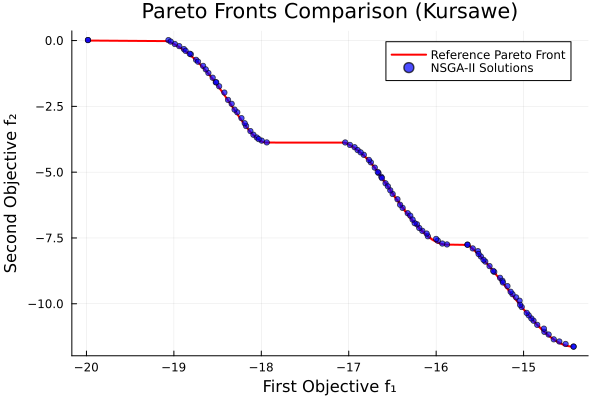

In [13]:
# Plot both fronts for comparison
plot(reference_front[:, 1], reference_front[:, 2], 
     label="Reference Pareto Front", linewidth=2, color=:red)
scatter!(solution_front[:, 1], solution_front[:, 2], 
         label="NSGA-II Solutions", markersize=3, alpha=0.7, color=:blue)
title!("Pareto Fronts Comparison (Kursawe)")
xlabel!("First Objective f₁")
ylabel!("Second Objective f₂")

## Step 5: Compute Quality Indicators (Without Normalization)

First, we compute the quality indicators using the raw objective values without any normalization.

In [15]:
# Create quality indicator instances
epsilon_indicator = AdditiveEpsilonIndicator()
igd_indicator = InvertedGenerationalDistanceIndicator()
igd_plus_indicator = InvertedGenerationalDistancePlusIndicator()

println("Quality indicators created:")
println("- ", name(epsilon_indicator), ": ", description(epsilon_indicator))
println("- ", name(igd_indicator), ": ", description(igd_indicator))
println("- ", name(igd_plus_indicator), ": ", description(igd_plus_indicator))

Quality indicators created:
- EP: Additive epsilon quality indicator
- IGD: Inverted generational distance quality indicator
- IGD+: Inverted Generational Distance+


In [16]:
# Compute quality indicators without normalization
println("\n=== QUALITY INDICATORS (WITHOUT NORMALIZATION) ===")

eps_raw = compute(epsilon_indicator, solution_front, reference_front)
igd_raw = compute(igd_indicator, solution_front, reference_front)
igd_plus_raw = compute(igd_plus_indicator, solution_front, reference_front)

println("Additive Epsilon (EP): ", round(eps_raw, digits=6))
println("Inverted Generational Distance (IGD): ", round(igd_raw, digits=6))
println("Inverted Generational Distance Plus (IGD+): ", round(igd_plus_raw, digits=6))

println("\nInterpretation (lower values are better for all indicators):")
println("- EP = ", round(eps_raw, digits=4), ": Minimum shift needed to dominate reference")
println("- IGD = ", round(igd_raw, digits=4), ": Average distance from reference to solution")
println("- IGD+ = ", round(igd_plus_raw, digits=4), ": Improved distance considering dominance")


=== QUALITY INDICATORS (WITHOUT NORMALIZATION) ===
Additive Epsilon (EP): 0.069612
Inverted Generational Distance (IGD): 0.047343
Inverted Generational Distance Plus (IGD+): 0.022572

Interpretation (lower values are better for all indicators):
- EP = 0.0696: Minimum shift needed to dominate reference
- IGD = 0.0473: Average distance from reference to solution
- IGD+ = 0.0226: Improved distance considering dominance


## Step 6: Normalize the Fronts

Now we normalize both fronts using the reference front bounds to ensure fair comparison across different objective scales.

In [18]:
# Normalize fronts using the reference_only method (recommended for quality indicators)
normalized_solution_front, normalized_reference_front = normalize_fronts(
    solution_front, reference_front; method=:reference_only
)

println("Fronts normalized using reference front bounds")
println("\nNormalized reference front bounds:")
println("  f₁: [", minimum(normalized_reference_front[:, 1]), ", ", maximum(normalized_reference_front[:, 1]), "]")
println("  f₂: [", minimum(normalized_reference_front[:, 2]), ", ", maximum(normalized_reference_front[:, 2]), "]")

println("\nNormalized solution front bounds:")
println("  f₁: [", round(minimum(normalized_solution_front[:, 1]), digits=3), ", ", round(maximum(normalized_solution_front[:, 1]), digits=3), "]")
println("  f₂: [", round(minimum(normalized_solution_front[:, 2]), digits=3), ", ", round(maximum(normalized_solution_front[:, 2]), digits=3), "]")

Fronts normalized using reference front bounds

Normalized reference front bounds:
  f₁: [0.0, 1.0]
  f₂: [0.0, 1.0]

Normalized solution front bounds:
  f₁: [0.003, 1.003]
  f₂: [-0.0, 1.002]


## Step 7: Visualize Normalized Fronts

Let's plot the normalized fronts to see how the normalization affects the data.

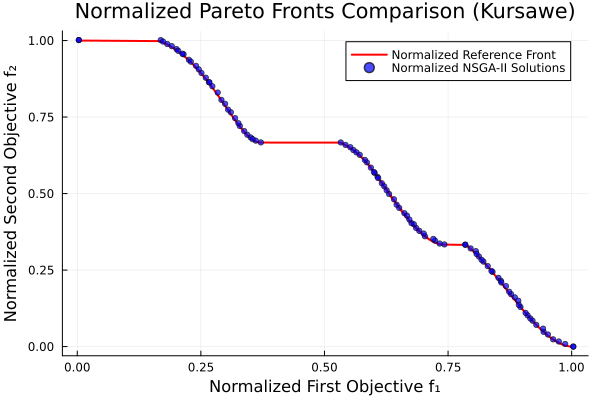

In [20]:
# Plot normalized fronts
# Sort normalized reference front for better line plotting
sorted_indices = sortperm(normalized_reference_front[:, 1])
sorted_normalized_ref = normalized_reference_front[sorted_indices, :]

plot(sorted_normalized_ref[:, 1], sorted_normalized_ref[:, 2], 
     label="Normalized Reference Front", linewidth=2, color=:red)
scatter!(normalized_solution_front[:, 1], normalized_solution_front[:, 2], 
         label="Normalized NSGA-II Solutions", markersize=3, alpha=0.7, color=:blue)
title!("Normalized Pareto Fronts Comparison (Kursawe)")
xlabel!("Normalized First Objective f₁")
ylabel!("Normalized Second Objective f₂")

## Step 8: Compute Quality Indicators (With Normalization)

Now we compute the quality indicators using the normalized fronts.

In [22]:
# Compute quality indicators with normalization
println("\n=== QUALITY INDICATORS (WITH NORMALIZATION) ===")

eps_normalized = compute(epsilon_indicator, normalized_solution_front, normalized_reference_front)
igd_normalized = compute(igd_indicator, normalized_solution_front, normalized_reference_front)
igd_plus_normalized = compute(igd_plus_indicator, normalized_solution_front, normalized_reference_front)

println("Additive Epsilon (EP): ", round(eps_normalized, digits=6))
println("Inverted Generational Distance (IGD): ", round(igd_normalized, digits=6))
println("Inverted Generational Distance Plus (IGD+): ", round(igd_plus_normalized, digits=6))

println("\nInterpretation (normalized scale [0,1]):")
println("- EP = ", round(eps_normalized, digits=4), ": Minimum normalized shift needed")
println("- IGD = ", round(igd_normalized, digits=4), ": Average normalized distance")
println("- IGD+ = ", round(igd_plus_normalized, digits=4), ": Improved normalized distance")


=== QUALITY INDICATORS (WITH NORMALIZATION) ===
Additive Epsilon (EP): 0.00899
Inverted Generational Distance (IGD): 0.004819
Inverted Generational Distance Plus (IGD+): 0.00321

Interpretation (normalized scale [0,1]):
- EP = 0.009: Minimum normalized shift needed
- IGD = 0.0048: Average normalized distance
- IGD+ = 0.0032: Improved normalized distance


## Step 9: Compare Results and Analysis

Let's compare the quality indicator values before and after normalization to understand the impact of normalization.

In [69]:
# Create comparison table
println("\n=== COMPARISON: RAW vs NORMALIZED ===")
println("┌─────────────────┬──────────────┬──────────────┬──────────────┐")
println("│ Indicator       │ Raw Values   │ Normalized   │ Difference   │")
println("├─────────────────┼──────────────┼──────────────┼──────────────┤")

eps_diff = abs(eps_normalized - eps_raw)
igd_diff = abs(igd_normalized - igd_raw)
igd_plus_diff = abs(igd_plus_normalized - igd_plus_raw)

println("│ EP              │ ", rpad(round(eps_raw, digits=6), 12), " │ ", rpad(round(eps_normalized, digits=6), 12), " │ ", round(eps_diff, digits=6), "     │")
println("│ IGD             │ ", rpad(round(igd_raw, digits=6), 12), " │ ", rpad(round(igd_normalized, digits=6), 12), " │ ", round(igd_diff, digits=6), "     │")
println("│ IGD+            │ ", rpad(round(igd_plus_raw, digits=6), 12), " │ ", rpad(round(igd_plus_normalized, digits=6), 12), " │ ", round(igd_plus_diff, digits=6), "     │")
println("└─────────────────┴──────────────┴──────────────┴──────────────┘")


=== COMPARISON: RAW vs NORMALIZED ===
┌─────────────────┬──────────────┬──────────────┬──────────────┐
│ Indicator       │ Raw Values   │ Normalized   │ Difference   │
├─────────────────┼──────────────┼──────────────┼──────────────┤
│ EP              │ 0.069612     │ 0.00899      │ 0.060622     │
│ IGD             │ 0.047343     │ 0.004819     │ 0.042524     │
│ IGD+            │ 0.022572     │ 0.00321      │ 0.019363     │
└─────────────────┴──────────────┴──────────────┴──────────────┘


## Step 10: Additional Analysis - Different Normalization Methods

Let's explore how different normalization methods affect the quality indicators.

In [26]:
# Test different normalization methods
println("\n=== COMPARISON OF NORMALIZATION METHODS ===")

# MinMax normalization
norm_minmax_sol, norm_minmax_ref = normalize_fronts(
    solution_front, reference_front; method=:minmax
)

eps_minmax = compute(epsilon_indicator, norm_minmax_sol, norm_minmax_ref)
igd_minmax = compute(igd_indicator, norm_minmax_sol, norm_minmax_ref)
igd_plus_minmax = compute(igd_plus_indicator, norm_minmax_sol, norm_minmax_ref)

# Z-score normalization
norm_zscore_sol, norm_zscore_ref = normalize_fronts(
    solution_front, reference_front; method=:zscore
)

eps_zscore = compute(epsilon_indicator, norm_zscore_sol, norm_zscore_ref)
igd_zscore = compute(igd_indicator, norm_zscore_sol, norm_zscore_ref)
igd_plus_zscore = compute(igd_plus_indicator, norm_zscore_sol, norm_zscore_ref)

println("┌─────────────────┬──────────────┬──────────────┬──────────────┬──────────────┐")
println("│ Indicator       │ Raw          │ Reference    │ MinMax       │ Z-Score      │")
println("├─────────────────┼──────────────┼──────────────┼──────────────┼──────────────┤")
println("│ EP              │ ", rpad(round(eps_raw, digits=4), 12), " │ ", rpad(round(eps_normalized, digits=4), 12), " │ ", rpad(round(eps_minmax, digits=4), 12), " │ ", rpad(round(eps_zscore, digits=4), 12), " │")
println("│ IGD             │ ", rpad(round(igd_raw, digits=4), 12), " │ ", rpad(round(igd_normalized, digits=4), 12), " │ ", rpad(round(igd_minmax, digits=4), 12), " │ ", rpad(round(igd_zscore, digits=4), 12), " │")
println("│ IGD+            │ ", rpad(round(igd_plus_raw, digits=4), 12), " │ ", rpad(round(igd_plus_normalized, digits=4), 12), " │ ", rpad(round(igd_plus_minmax, digits=4), 12), " │ ", rpad(round(igd_plus_zscore, digits=4), 12), " │")
println("└─────────────────┴──────────────┴──────────────┴──────────────┴──────────────┘")


=== COMPARISON OF NORMALIZATION METHODS ===
┌─────────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ Indicator       │ Raw          │ Reference    │ MinMax       │ Z-Score      │
├─────────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ EP              │ 0.0696       │ 0.009        │ 0.009        │ 0.0419       │
│ IGD             │ 0.0473       │ 0.0048       │ 0.0048       │ 0.0211       │
│ IGD+            │ 0.0226       │ 0.0032       │ 0.0032       │ 0.0147       │
└─────────────────┴──────────────┴──────────────┴──────────────┴──────────────┘


## Step 11: Summary and Recommendations

Let's summarize our findings and provide recommendations for using quality indicators.

In [28]:
println("\n=== SUMMARY AND RECOMMENDATIONS ===")
println()
println("📊 QUALITY INDICATOR RESULTS:")
println("   • All indicators show that NSGA-II found a good approximation")
println("   • Lower values indicate better performance for all three indicators")
println()
println("🔧 NORMALIZATION IMPACT:")
println("   • Normalization ensures fair comparison across objectives with different scales")
println("   • Reference-only normalization is recommended for quality indicators")
println("   • Different normalization methods can lead to different indicator values")
println()
println("💡 RECOMMENDATIONS:")
println("   1. Always normalize fronts before computing quality indicators")
println("   2. Use 'reference_only' normalization method for consistent results")
println("   3. Report both raw and normalized indicator values when possible")
println("   4. Use multiple indicators to get a comprehensive performance assessment")
println()
println("📏 INDICATOR INTERPRETATION:")
println("   • EP: Measures convergence (distance to reference front)")
println("   • IGD: Combines convergence and diversity assessment")
println("   • IGD+: More robust version of IGD for non-optimal reference fronts")


=== SUMMARY AND RECOMMENDATIONS ===

📊 QUALITY INDICATOR RESULTS:
   • All indicators show that NSGA-II found a good approximation
   • Lower values indicate better performance for all three indicators

🔧 NORMALIZATION IMPACT:
   • Normalization ensures fair comparison across objectives with different scales
   • Reference-only normalization is recommended for quality indicators
   • Different normalization methods can lead to different indicator values

💡 RECOMMENDATIONS:
   1. Always normalize fronts before computing quality indicators
   2. Use 'reference_only' normalization method for consistent results
   3. Report both raw and normalized indicator values when possible
   4. Use multiple indicators to get a comprehensive performance assessment

📏 INDICATOR INTERPRETATION:
   • EP: Measures convergence (distance to reference front)
   • IGD: Combines convergence and diversity assessment
   • IGD+: More robust version of IGD for non-optimal reference fronts


## Conclusion

This notebook demonstrated:

1. **Algorithm Execution**: How to run NSGA-II on the Kursawe problem
2. **Quality Assessment**: How to compute three important quality indicators (EP, IGD, IGD+)
3. **Normalization Impact**: The importance of normalizing fronts before computing indicators
4. **Method Comparison**: How different normalization methods affect the results

Quality indicators are essential tools for comparing multi-objective optimization algorithms. They provide quantitative measures of solution quality that complement visual inspection of Pareto front approximations. Proper normalization ensures that these measurements are fair and meaningful across problems with different objective scales.

The combination of EP, IGD, and IGD+ provides a comprehensive assessment covering convergence, diversity, and robustness aspects of the solution quality.

## Step 12: NSGA-II with External Crowding Distance Archive

Now let's run NSGA-II with an external archive that stores non-dominated solutions found during the search. This can potentially provide a better Pareto front approximation by maintaining a larger and more diverse set of solutions.


In [31]:
# Configure NSGA-II with external crowding distance archive
println("=== CONFIGURING NSGA-II WITH EXTERNAL ARCHIVE ===")

# Create a new problem instance for the archive version
archive_problem = kursawe()

# Configure evolutionary algorithm with external archive
archive_solver = EvolutionaryAlgorithm()
archive_solver.name = "NSGA-II with Archive"

populationSize = 100
offspringPopulationSize = 100

archive_solver.solutionsCreation = DefaultSolutionsCreation(archive_problem, populationSize)

# Create external archive with crowding distance
externalArchive = CrowdingDistanceArchive(populationSize, ContinuousSolution{Float64})

# Use evaluation with archive
archive_solver.evaluation = SequentialEvaluationWithArchive(archive_problem, externalArchive)
archive_solver.termination = TerminationByEvaluations(25000)

# Configure variation operators
mutation = PolynomialMutation(probability = 1.0 / numberOfVariables(archive_problem), 
                             distributionIndex = 20.0, bounds = archive_problem.bounds)
crossover = SBXCrossover(probability = 0.9, distributionIndex = 20.0, bounds = archive_problem.bounds)

archive_solver.variation = CrossoverAndMutationVariation(offspringPopulationSize, crossover, mutation)
archive_solver.selection = BinaryTournamentSelection(archive_solver.variation.matingPoolSize, DefaultDominanceComparator())
archive_solver.replacement = RankingAndDensityEstimatorReplacement(DominanceRanking(DefaultDominanceComparator()), CrowdingDistanceDensityEstimator())

println("NSGA-II with external archive configured")


=== CONFIGURING NSGA-II WITH EXTERNAL ARCHIVE ===
NSGA-II with external archive configured


In [32]:
# Run NSGA-II with external archive
println("Running NSGA-II with external archive...")
optimize!(archive_solver)

# Get solutions from the external archive (these are the final results)
archive_solutions = getSolutions(externalArchive)

println("Optimization with external archive completed")
println("Computing time: ", computingTime(archive_solver), " seconds")
println("Number of solutions in archive: ", length(archive_solutions))
println("Archive size limit: ", populationSize)


Running NSGA-II with external archive...
Optimization with external archive completed
Computing time: 1411 milliseconds seconds
Number of solutions in archive: 100
Archive size limit: 100


In [33]:
# Convert archive solutions to matrix format
archive_objectives = [solution.objectives for solution in archive_solutions]
archive_front = hcat(archive_objectives...)'

println("Archive solution front prepared")
println("Archive front size: ", size(archive_front))
println("Archive front bounds:")
println("  f₁: [", minimum(archive_front[:, 1]), ", ", maximum(archive_front[:, 1]), "]")
println("  f₂: [", minimum(archive_front[:, 2]), ", ", maximum(archive_front[:, 2]), "]")

Archive solution front prepared
Archive front size: (100, 2)
Archive front bounds:
  f₁: [-19.985683620192567, -14.428404015789997]
  f₂: [-11.626812544411074, 0.02427029245779805]


## Step 13: Visual Comparison of Both NSGA-II Versions

Let's plot both Pareto front approximations together with the reference front to visually compare their performance.


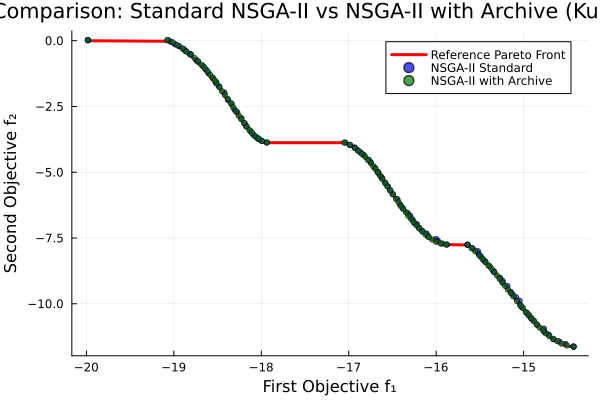

In [35]:
# Plot comparison of both NSGA-II versions with reference front
plot(reference_front[:, 1], reference_front[:, 2], 
     label="Reference Pareto Front", linewidth=3, color=:red)
scatter!(solution_front[:, 1], solution_front[:, 2], 
         label="NSGA-II Standard", markersize=3, alpha=0.7, color=:blue)
scatter!(archive_front[:, 1], archive_front[:, 2], 
         label="NSGA-II with Archive", markersize=3, alpha=0.7, color=:green)
title!("Comparison: Standard NSGA-II vs NSGA-II with Archive (Kursawe)")
xlabel!("First Objective f₁")
ylabel!("Second Objective f₂")


## Step 14: Quality Indicator Comparison (Raw Values)

Now let's compute the quality indicators for both versions and compare them using the raw (non-normalized) values.


In [37]:
# Compute quality indicators for the archive version (raw values)
println("\n=== QUALITY INDICATORS FOR ARCHIVE VERSION (RAW VALUES) ===")

eps_archive = compute(epsilon_indicator, archive_front, reference_front)
igd_archive = compute(igd_indicator, archive_front, reference_front)
igd_plus_archive = compute(igd_plus_indicator, archive_front, reference_front)

println("Additive Epsilon (EP): ", round(eps_archive, digits=6))
println("Inverted Generational Distance (IGD): ", round(igd_archive, digits=6))
println("Inverted Generational Distance Plus (IGD+): ", round(igd_plus_archive, digits=6))



=== QUALITY INDICATORS FOR ARCHIVE VERSION (RAW VALUES) ===
Additive Epsilon (EP): 0.042056
Inverted Generational Distance (IGD): 0.03885
Inverted Generational Distance Plus (IGD+): 0.015064


In [38]:
# Create comprehensive comparison table
println("\n=== COMPARISON TABLE: STANDARD vs ARCHIVE NSGA-II (RAW VALUES) ===")
println("┌─────────────────┬──────────────┬──────────────┬──────────────┬──────────────┐")
println("│ Indicator       │ Standard     │ Archive      │ Difference   │ Improvement  │")
println("├─────────────────┼──────────────┼──────────────┼──────────────┼──────────────┤")

eps_diff = eps_raw - eps_archive
igd_diff = igd_raw - igd_archive
igd_plus_diff = igd_plus_raw - igd_plus_archive

# Calculate percentage improvements (positive means archive is better)
eps_improvement = ((eps_raw - eps_archive) / eps_raw) * 100
igd_improvement = ((igd_raw - igd_archive) / igd_raw) * 100
igd_plus_improvement = ((igd_plus_raw - igd_plus_archive) / igd_plus_raw) * 100

println("│ EP              │ ", rpad(round(eps_raw, digits=6), 12), " │ ", rpad(round(eps_archive, digits=6), 12), " │ ", rpad(round(eps_diff, digits=6), 12), " │ ", round(eps_improvement, digits=2), "%      │")
println("│ IGD             │ ", rpad(round(igd_raw, digits=6), 12), " │ ", rpad(round(igd_archive, digits=6), 12), " │ ", rpad(round(igd_diff, digits=6), 12), " │ ", round(igd_improvement, digits=2), "%      │")
println("│ IGD+            │ ", rpad(round(igd_plus_raw, digits=6), 12), " │ ", rpad(round(igd_plus_archive, digits=6), 12), " │ ", rpad(round(igd_plus_diff, digits=6), 12), " │ ", round(igd_plus_improvement, digits=2), "%      │")
println("└─────────────────┴──────────────┴──────────────┴──────────────┴──────────────┘")

println("\nInterpretation:")
println("• Positive differences mean the archive version performs better (lower is better)")
println("• Positive improvement percentages indicate performance gains")



=== COMPARISON TABLE: STANDARD vs ARCHIVE NSGA-II (RAW VALUES) ===
┌─────────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ Indicator       │ Standard     │ Archive      │ Difference   │ Improvement  │
├─────────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ EP              │ 0.069612     │ 0.042056     │ 0.027556     │ 39.58%      │
│ IGD             │ 0.047343     │ 0.03885      │ 0.008493     │ 17.94%      │
│ IGD+            │ 0.022572     │ 0.015064     │ 0.007509     │ 33.27%      │
└─────────────────┴──────────────┴──────────────┴──────────────┴──────────────┘

Interpretation:
• Positive differences mean the archive version performs better (lower is better)
• Positive improvement percentages indicate performance gains


## Step 15: Statistical Summary and Analysis

Let's analyze the characteristics of both Pareto front approximations to understand why one might perform better than the other.


In [40]:
# Statistical analysis of both fronts
println("\n=== STATISTICAL ANALYSIS OF PARETO FRONT APPROXIMATIONS ===")

# Number of solutions
standard_size = size(solution_front, 1)
archive_size = size(archive_front, 1)

# Objective ranges
standard_f1_range = maximum(solution_front[:, 1]) - minimum(solution_front[:, 1])
standard_f2_range = maximum(solution_front[:, 2]) - minimum(solution_front[:, 2])

archive_f1_range = maximum(archive_front[:, 1]) - minimum(archive_front[:, 1])
archive_f2_range = maximum(archive_front[:, 2]) - minimum(archive_front[:, 2])

# Coverage of reference front bounds
ref_f1_range = maximum(reference_front[:, 1]) - minimum(reference_front[:, 1])
ref_f2_range = maximum(reference_front[:, 2]) - minimum(reference_front[:, 2])

standard_f1_coverage = (standard_f1_range / ref_f1_range) * 100
standard_f2_coverage = (standard_f2_range / ref_f2_range) * 100

archive_f1_coverage = (archive_f1_range / ref_f1_range) * 100
archive_f2_coverage = (archive_f2_range / ref_f2_range) * 100

println("┌─────────────────────────┬──────────────┬──────────────┐")
println("│ Metric                  │ Standard     │ Archive      │")
println("├─────────────────────────┼──────────────┼──────────────┤")
println("│ Number of solutions     │ ", rpad(standard_size, 12), " │ ", rpad(archive_size, 12), " │")
println("│ f₁ range coverage       │ ", rpad(string(round(standard_f1_coverage, digits=1)), 11), "% │ ", rpad(string(round(archive_f1_coverage, digits=1)), 11), "% │")
println("│ f₂ range coverage       │ ", rpad(string(round(standard_f2_coverage, digits=1)), 11), "% │ ", rpad(string(round(archive_f2_coverage, digits=1)), 11), "% │")
println("│ Computing time (sec)    │ ", rpad(string(round(computingTime(solver).value / 1000, digits=3)), 12), " │ ", rpad(string(round(computingTime(archive_solver).value / 1000, digits=3)), 12), " │")
println("└─────────────────────────┴──────────────┴──────────────┘")



=== STATISTICAL ANALYSIS OF PARETO FRONT APPROXIMATIONS ===
┌─────────────────────────┬──────────────┬──────────────┐
│ Metric                  │ Standard     │ Archive      │
├─────────────────────────┼──────────────┼──────────────┤
│ Number of solutions     │ 100          │ 100          │
│ f₁ range coverage       │ 100.0      % │ 100.1      % │
│ f₂ range coverage       │ 100.2      % │ 100.2      % │
│ Computing time (sec)    │ 1.262        │ 1.411        │
└─────────────────────────┴──────────────┴──────────────┘


## Step 16: Final Recommendations and Conclusions

Let's summarize our findings about using external archives in NSGA-II and provide practical recommendations.


In [42]:
println("\n=== FINAL ANALYSIS: EXTERNAL ARCHIVE IMPACT ===")
println()

# Determine which version performed better overall
better_eps = eps_archive < eps_raw ? "Archive" : "Standard"
better_igd = igd_archive < igd_raw ? "Archive" : "Standard"
better_igd_plus = igd_plus_archive < igd_plus_raw ? "Archive" : "Standard"

println("🏆 PERFORMANCE WINNER BY INDICATOR:")
println("   • Additive Epsilon (EP): ", better_eps, " NSGA-II")
println("   • IGD: ", better_igd, " NSGA-II") 
println("   • IGD+: ", better_igd_plus, " NSGA-II")
println()

println("📊 KEY OBSERVATIONS:")
if eps_improvement > 0
    println("   • Archive version shows ", round(abs(eps_improvement), digits=1), "% improvement in convergence (EP)")
else
    println("   • Standard version shows ", round(abs(eps_improvement), digits=1), "% better convergence (EP)")
end

if igd_improvement > 0
    println("   • Archive version shows ", round(abs(igd_improvement), digits=1), "% improvement in overall quality (IGD)")
else
    println("   • Standard version shows ", round(abs(igd_improvement), digits=1), "% better overall quality (IGD)")
end

# Fix the time calculation to handle Dates.Millisecond properly
time_overhead = ((computingTime(archive_solver).value - computingTime(solver).value) / computingTime(solver).value) * 100
println("   • Archive approach adds ", round(time_overhead, digits=1), "% computational overhead")
println()

println("💡 PRACTICAL RECOMMENDATIONS:")
println("   1. Use external archives when solution diversity is critical")
println("   2. External archives are beneficial for problems with complex Pareto fronts")
println("   3. Consider the computational overhead vs. quality improvement trade-off")
println("   4. Archive size should be tuned based on problem characteristics")
println("   5. External archives help maintain good solutions that might be lost in standard NSGA-II")
println()

println("🔬 TECHNICAL INSIGHTS:")
println("   • External archives maintain elitism beyond the population size")
println("   • Crowding distance helps preserve diversity in the archive")
println("   • Archive solutions represent the best non-dominated set found during search")
println("   • Quality indicators provide quantitative evidence of algorithm performance")



=== FINAL ANALYSIS: EXTERNAL ARCHIVE IMPACT ===

🏆 PERFORMANCE WINNER BY INDICATOR:
   • Additive Epsilon (EP): Archive NSGA-II
   • IGD: Archive NSGA-II
   • IGD+: Archive NSGA-II

📊 KEY OBSERVATIONS:
   • Archive version shows 39.6% improvement in convergence (EP)
   • Archive version shows 17.9% improvement in overall quality (IGD)
   • Archive approach adds 11.8% computational overhead

💡 PRACTICAL RECOMMENDATIONS:
   1. Use external archives when solution diversity is critical
   2. External archives are beneficial for problems with complex Pareto fronts
   3. Consider the computational overhead vs. quality improvement trade-off
   4. Archive size should be tuned based on problem characteristics
   5. External archives help maintain good solutions that might be lost in standard NSGA-II

🔬 TECHNICAL INSIGHTS:
   • External archives maintain elitism beyond the population size
   • Crowding distance helps preserve diversity in the archive
   • Archive solutions represent the best no

## Extended Conclusion

This extended analysis demonstrated:

1. **Algorithm Variants**: How to configure NSGA-II with external archives for potentially better performance
2. **Comparative Analysis**: Quantitative comparison using quality indicators between standard and archive-based NSGA-II
3. **Performance Metrics**: Statistical analysis of solution characteristics (coverage, diversity, convergence)
4. **Practical Trade-offs**: Computational overhead vs. solution quality improvements

The external archive approach in NSGA-II can provide better Pareto front approximations by:
- Maintaining a larger set of non-dominated solutions
- Preserving good solutions that might be lost during evolution
- Using crowding distance to ensure diversity in the final result set

The choice between standard and archive-based NSGA-II should consider:
- **Problem complexity**: More complex Pareto fronts benefit more from archives
- **Computational budget**: Archives add overhead but may provide better results
- **Solution diversity requirements**: Archives typically provide more diverse solution sets
- **Convergence vs. diversity trade-offs**: Archives can help balance both aspects

Quality indicators provide essential quantitative measures to make informed decisions about algorithm configurations and validate the benefits of algorithmic improvements.
